# 1. Purpose & Data

This assignment and the code that follows go through my personal workout data in order to find patterns that are relevant to each of the sports and then being able to classify them accordingly. The data is in a spreadsheet format that was exported from my phone's native health application linked to my sports band that I wear during these workouts.

The various sections that are included in the data are:
- Workout (str) : What type of workout was recorded.
- Duration (int): Time in minutes that the workout was done over.
- Burned(kcal) (int): Number of calories that were burnt during the workout.
- Warmup (int): Time in minutes that was spent during warmup.
- Fat_burn (int): Time in minutes that was spent during fat burning.
- Endurance (int): Time in minutes that was spent during endurance.
- Anareboic (int): Time in minutes that was spent during anaerobic respiration.
- Threshold (Boolean): 1 if heart rate crossed 190 beats per minute during the workout, 0 otherwise.
- Max_heartrate (int): The maximum heart rate reached during the workout.
- Avg_heartrate (int): The average heart rate during the workout.

Warmup, fat burn, endurance, and anaerobic are the four categories that the workout is distributed into based on my heart rate and burning of calories. How exactly this distribution is not available in public data that could be found on Oneplus's** official website.

**Oneplus is the name of the brand that both my phone and my sports band belong to.

# 2. Importing the data

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# importing sklearn libraries
#importing sklearn libraries
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [2]:
data = pd.read_csv('data.csv')
data.head()

,Workout,Duration,Burned(kcal),warmup,fat_burn,endurance,anaerobic,threshold,max_heartrate,avg_heartrate
0,Squash,79,754,12,21,33,13,0,178,144
1,Basketball,62,653,4,19,31,8,0,165,139
2,Basketball,59,648,3,17,29,10,0,168,142
3,Squash,91,972,14,22,42,13,1,197,157
4,Squash,98,1031,13,18,52,15,1,203,161


# 3. Cleaning and pre-processing data

In order to use the data that I have, the workout types need to be converted to numeric values so that they can be processed by the models that we use. For this, I used a map function that can be found below 

In [3]:
"""
0 - Squash
1 - Basketball
2 - Volleyball
3 - Walk
4 - Gym
"""
# making a copy of the data to not affect the original data

df = data.copy()

mapper = {'Squash': 0, 'Basketball':1, 'Volleyball':2, 'Walk':3, 'Gym':4}
df['Workout'] = df['Workout'].map(mapper)
df.head()

,Workout,Duration,Burned(kcal),warmup,fat_burn,endurance,anaerobic,threshold,max_heartrate,avg_heartrate
0,0,79,754,12,21,33,13,0,178,144
1,1,62,653,4,19,31,8,0,165,139
2,1,59,648,3,17,29,10,0,168,142
3,0,91,972,14,22,42,13,1,197,157
4,0,98,1031,13,18,52,15,1,203,161


### Descriptive stats

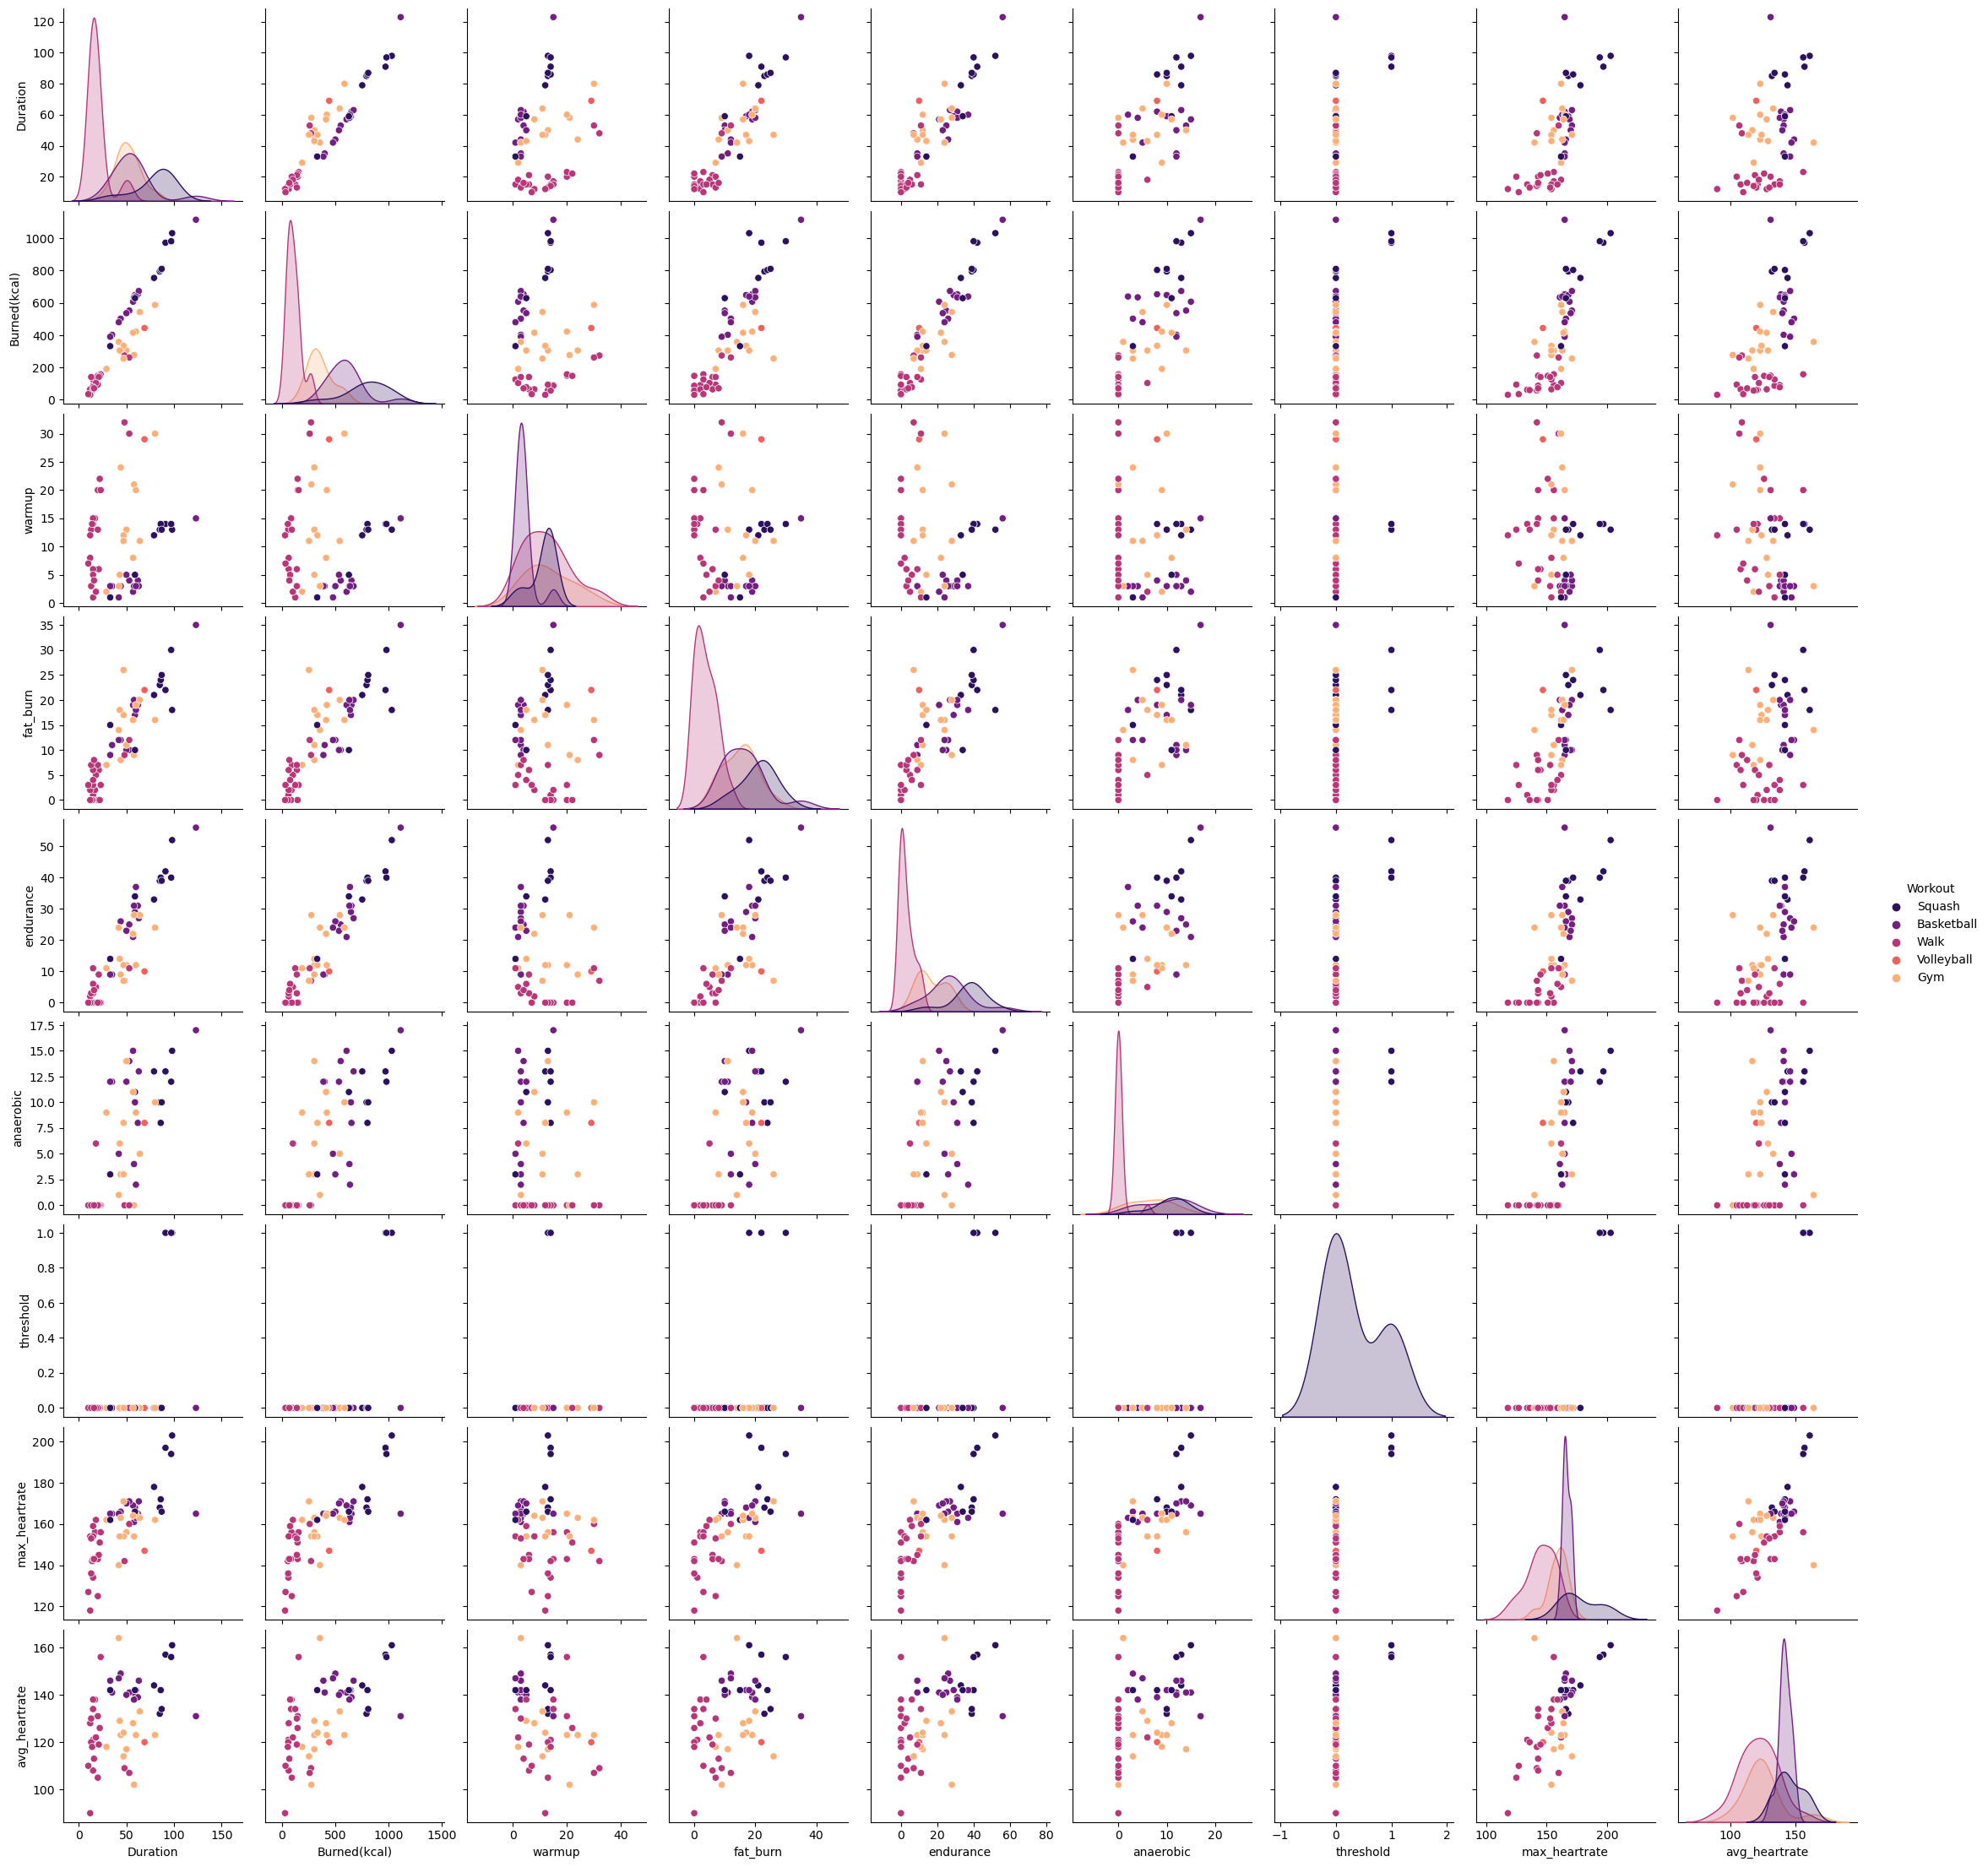

In [4]:
sns.pairplot(data, hue='Workout', palette="magma", kind="scatter")

Looking at the plots above we can see that there are definitely patterns in the data that a model can use to perform classification accordingly. Some interesting patterns that are visually clear are between duration and number of calories burnt. Moreover, duration also seems to be correlated with both fat burn and endurance. However, these patterns are not seen in anaerobic and warmup despite them being categories of respiration as well.

We can also visualize these correlations using a correlation matrix. See below.

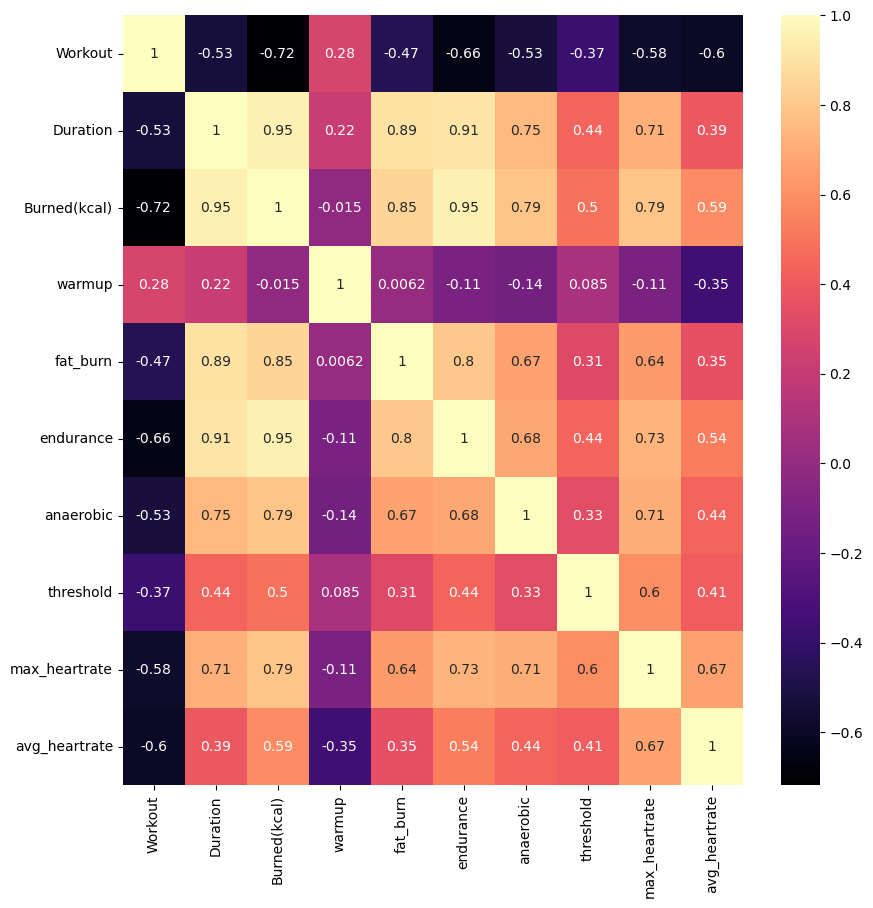

In [5]:
# Plot the correlation matrix
corr = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, cmap="magma")
plt.show()

Next, let's visualize some of the occurence frequencies within the data to see how much data for each type of workout will the model have.

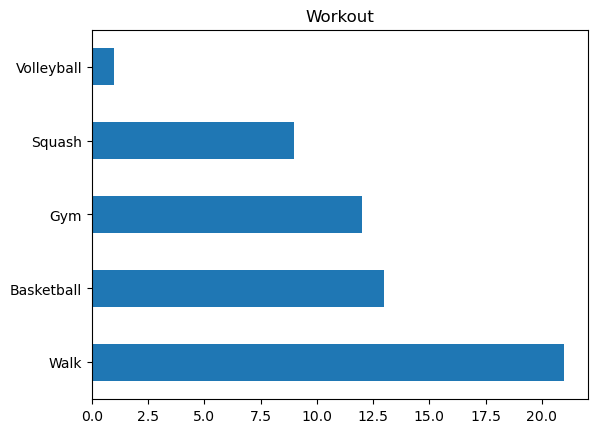

In [6]:
plt.figure()
data['Workout'].value_counts().plot(kind='barh', title='Workout')
plt.show()

It seems that the model does have plenty of data for all the various workouts except for volleyball since that was a rare activity. Thus, any model should be able to learn patterns in the sports and be able to classify them to the respective categories.

General descriptive statistics are printed in the table below but they are not relevant to the discussion for now so I will not go into detail about them.

In [7]:
data.describe()

,Duration,Burned(kcal),warmup,fat_burn,endurance,anaerobic,threshold,max_heartrate,avg_heartrate
count,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000
mean,45.553571,392.428571,10.750000,12.160714,17.053571,5.625000,0.053571,158.410714,130.857143
std,27.338896,291.677584,8.235731,8.597625,15.090538,5.528644,0.227208,15.941686,15.709208
min,10.000000,31.000000,1.000000,0.000000,0.000000,0.000000,0.000000,118.000000,90.000000
25%,19.500000,137.250000,3.000000,5.750000,3.750000,0.000000,0.000000,150.000000,120.000000
50%,45.500000,333.000000,11.000000,11.000000,12.000000,4.500000,0.000000,162.000000,131.500000
75%,60.000000,612.500000,14.000000,19.000000,28.000000,10.250000,0.000000,166.000000,142.000000
max,123.000000,1114.000000,32.000000,35.000000,56.000000,17.000000,1.000000,203.000000,164.000000


# 4. Task and splitting the data

For this pipeline, the main focus is building the best classification model for the data. The purpose is to be able to classify the sports into the correct categories.

Such classification models are in high demand nowadays as most people forget to manually start their workouts and as such data is not recorded despite wearing sports watches. A classification model that can learn the patterns that are present in all these sports could be added as a feature to these sports watches so that it can auto-detect workouts and perhaps alert the wearer to start the workout once it is sure that it is in-progress e.g. I start playing squash but forget to start the workout on my watch. Such models would enable my band to alert me that I should start squash as a workout and then use the data to keep the data-tracking consistent.

The data has to be split into three categories: training, validation and testing. This is the general best practice in the domain of Machine Learning. Not using validation sets might lead to false estimates of confidence in the model accuracy and other metrics. The training data is the part which we feed to our model from which the learning of patterns is done. Once the model learns, we use the validation sets to understand the model's performance across different model types and hyperparameter tuning.

Splitting the data in this case is a hard task. General guidelines indicate that 80% training data, 10% validation data, and 10% testing data is a good split (Baheti, 2023). However, since our data is limited, 10% might not be enough. Since classification models usually include 2-3 parameters, my personal opinion is to use 70% as training data, 15% as validation and 15% for testing data.

The training dataset is supposed to be as representative as possible along with being unbiased. Thus, the split needs to be randomized as well and can't be hand-picked. The validation set acts as an independent, unbiased dataset for comparing performances. The test set should never be used before the final predictions by the final optimal model because looking at metrics on the test case beforehand is a type of overfitting leading to unreliable performance on unseen data.

In [8]:
# defining the outcome and the features of the model
y = df['Workout'].values
X = df.drop(['Workout'], axis = 1).values

# splitting the data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)
# splitting the test set from above into validation and test sets.
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=23)

# 5. Model Explanation & Training

### Classification Models
Classification models are used in Machine Learning to predict the class or category of a new input data point based on its features. Inputs for classification models are a set of values for certain features (predictors, independent variables etc.) and they output a class label (the target variable) based on the relationship between the features and the class labels observed in the training data. Classification models have many uses in the real world. They are used in spam detection, medical diagnosis, credit card fraud detection, and many more. The most common classification models are logistic regression, decision trees, random forests, and support vector machines. In this pipeline, I will be using random forests, K-nearest neighbors, and support vector machines.

#### Model 1: Random Forest
Random forests use a collection of decision trees to make more accurate predictions than a single decision tree. A decision tree is binary tree structure where each node is a feature and each leaf is a class label. The decision tree is built by splitting the data into two parts based on the feature value. The splitting is done in a way that the information gain is maximized. The information gain is the difference between the entropy of the parent node and the weighted sum of the entropy of the child nodes. The entropy is the measure of the impurity of the data. The main idea is to maximize information gain by minimizing impurity in the leaves.  
Random forests use multiple decision trees to make predictions. The algorithm is as follows:
1. Randomly select a subset of the training data.
2. Randomly select a subset of the features.
3. Build a decision tree using the subset of the data and features.
4. Repeat steps 1-3 for a number of times.
5. Aggregate the predictions of the decision trees to make the final prediction.
  
The key idea behind random forests is that by averaging the predictions of multiple decision trees, the noise and the biases of each individual tree are reduced finding the sweet balance between bias and variance. This leads to more **accurate** and **stable** predictions. Not only are they more robust and accurate, they also provide a measure of feature importance which can be used to understand which features are more important for the model to make predictions. This is useful for feature selection and feature engineering. They are also more suited for handling large datasets and high-dimensional data.  
Random forests use the idea of bagging (bootstrap aggregation) and feature sampling to construct a collection of trees (the forest) and then make them work together to improve prediction accuracy.  
The main mathematics behind random forests is the following:
For each tree, the split is done by selecting predictor $X_j$ and the cut point, s to split the data into two regions, such that we satisfy the following equations: $R_1(j, s) = {X | X_j < s}$ & $R_2(j, s) = {X | X_j \geq s}$.  
The splits seek to minimize: $\sum_{i : x_i \in R_1(j, s)} (y_i - \hat{y}_{R_1})^2 + \sum_{i : x_i \in R_2(j, s)} (y_i - \hat{y}_{R_2})^2$  
where $\hat{y}_{R_1}$ and $\hat{y}_{R_2}$ are the average response values for the observations in the two regions.  
The entropy is calculated using: $\sum_{i=1}^{C} -f_i log(f_i)$; where $f_i$ is the frequency of label i at a dnode and C is the number of unique labels.  
The Gini impurity is calculated using: $\sum_{i=1}^{C} f_i (1 - f_i)$.  
Finally, since the idea is to maximize the information gain, this is done through: $Gain(T, X) = Entropy(T) - Entropy(T, X)$; where T is the target variable, X is the feature to be split on, and Entropy(T, X) is the entropy calculated after the data is split on feature X. (Ronaghan, 2019)

#### Model 2: K-Nearest Neighbors
K-Nearest Neighbors is a simple algorithm that stores all available cases and classifies new cases based on a similarity measure. The similarity measure is the distance between the new case and the stored cases. The new case is classified by a majority vote of its k nearest neighbors, with the case being assigned to the class most common among its k nearest neighbors.  
The distance metric generally used is the Euclidean distance. The Euclidean distance between two points is the length of the line segment connecting them. However, other metrics e.g. Manhattan distance, Minkowski distance, etc. can also be used.
K-NN has several advantages. It is simple to implement, it is versatile, it is non-parametric, it is robust to noisy training data, and it is effective if the training data is large. It is also able to handle non-linear relationships between the features and the target variable.  
However, it has several disadvantages as well. It is computationally expensive, it is sensitive to irrelevant features, and it is sensitive to the scale of the data. The choice of k is also important and can have a significant impact on the performance of the model.  
In practice, K-NN is used as a baseline algorithm to compare the performance of other more complex algorithms. It is also used when the data is relatively small and decision boundary is highly non-linear. It is also used when the data is high-dimensional. Such a model is also quick to update because it just stores the new training data in the model and does not require retraining. However, it does have O(n) space complexity because it stores all the training data.

### Model 3: Support Vector Machines
Support Vector Machines are a set of supervised learning methods used for classification, regression and outliers detection. The goal of SVM is to find a hyperplane in an N-dimensional space (N is the number of features) that distinctly classifies the data points.  
The hyperplane is chosen such that the distance between the hyperplane and the nearest data points of any class is maximized. The data points that are closest to the hyperplane are called support vectors. The hyperplane is chosen such that the margin between the two classes is maximized. The margin is the distance between the hyperplane and the support vectors.  
SVMs can be used for linearly separable data as well as non-linearly separable data. For non-linearly separable data, the kernel trick is used. The kernel trick is a method of mapping data into a higher dimensional space so that the data becomes linearly separable. The kernel function is a function that takes two inputs and returns a scalar by calculating a dot product. The most common kernel functions are the linear, polynomial, and radial basis function (RBF) kernels.  
SVMS have several advantages. They have high accuracy on both linearly separable (a linear line can separate the classes). SVMs are robust as they are less sensitive to outliers as compared to other algorithms. They can handle a large range of feature spaces, including high dimensional data which makes them flexible.  
The limitations of SVMs include scalability because they are computationally expensive for large datasets and retraining. Choosing the appropriate kernel and tuning the hyperparameters is also a challenge.  
Interpretability of SVMs is a topic of debate. In some cases where the boundary is low dimensional, they are easy to interpret but high-dimensional boundary can be difficult to interpret.

In [9]:
# defining the models.
# For KNN: p=2 is for Euclidean distance. Default, neighbors = 5
# For SVM: default kernel = rbf, C = 1, gamma = scale (1/n_features)
# For RF: default n_estimators = 100, max_depth = None (no limit), max_features = sqrt(n_features)
models = {'KNN': KNeighborsClassifier(p=2),
          'SVM': SVC(),
          'Random Forest': RandomForestClassifier()}

# we iterate over all the models, fit the training data and then check metric against validation set
for name, model in models.items():
    model.fit(X_train, y_train)
    test_score = model.score(X_val, y_val)
    print(f'{name} validation accuracy: {test_score:.3f}')

KNN validation accuracy: 0.750
SVM validation accuracy: 0.750
Random Forest validation accuracy: 1.000


# 6. Hyperparameter tuning

Since the Random Forest model performs the best out of the three, we will now perform hyperparamter tuning on the model to find the best hyperparameters for the model. This is done through the use of a grid search. A grid search is an exhaustive search over specified parameter values for an estimator. The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.

In [10]:
kf = KFold(n_splits=5, shuffle=True, random_state=23)
# we pass the model paramters that we want it to train on and check which model performs best
# n_estimators is the number of trees in the forest. Default is 100.
# max_depth is the maximum depth of the tree. If default None, nodes are expanded until pure.
param_grid = {'n_estimators': [10, 50, 100, 200, 500], 
            'max_depth': [2, 3, 4, 5, 10, 20, 50]}
# since we aren't concerned with the absolute metrics and are only comparing, we will use accuracy.
RF = RandomForestClassifier()
RF_cv = GridSearchCV(RF, param_grid, cv=kf, scoring='accuracy')
RF_cv.fit(X_train, y_train)
print(f'Best parameters: {RF_cv.best_params_}, Best score: {RF_cv.best_score_:.3f}')

Best parameters: {'max_depth': 20, 'n_estimators': 50}, Best score: 0.868


# 7. Prediction and Performance metrics

We have our optimal model from the data above. Now we can use this model to make predictions on the test data. We will also use the test data to evaluate the performance of the model. The performance metrics we will use are the following:
* Accuracy
* Precision
* Recall
* F1 score

These are all important metrics to evaluate the performance of a classification model. The accuracy is the number of correct predictions divided by the total number of predictions. The precision is the number of true positives divided by the total number of true positives and false positives. The recall is the number of true positives divided by the total number of true positives and false negatives. The F1 score is the harmonic mean of the precision and recall.

In [11]:
# getting the best parameters and fitting the model
best_depth = RF_cv.best_params_['max_depth']
best_n_estimators = RF_cv.best_params_['n_estimators']
RF_best = RandomForestClassifier(n_estimators = best_n_estimators, max_depth = best_depth)
RF_best.fit(X_train, y_train)
# predicting unseen data
y_pred = RF_best.predict(X_test)
# checking the accuracy on the test set
accuracy = RF_best.score(X_test, y_test)
print(f'Accuracy on test data: {accuracy:.3f}')
# checking the precision, recall and f1-score
precision = metrics.precision_score(y_test, y_pred, average='weighted')
print(f'Precision on test data: {precision:.3f}')
# checking recall
recall = metrics.recall_score(y_test, y_pred, average='weighted')
print(f'Recall on test data: {recall:.3f}')
# checking f1-score
f1 = metrics.f1_score(y_test, y_pred, average='weighted')
print(f'F1-score on test data: {f1:.3f}')

Accuracy on test data: 0.778
Precision on test data: 0.861
Recall on test data: 0.778
F1-score on test data: 0.775


#### Discussion of metrics

From the results, it seems that the model is quite good at predicting the type of workout based on the best fit model. This shows that the model is able to generalize well. The model is also able to predict the type of workout with a high precision and recall. This means that the model is able to predict the type of workout with a high degree of confidence. The F1 score is also high, which means that the model is able to predict the type of workout with a high degree of accuracy.  

# 8. Conclusion

The final step in our pipeline is to visualize feature importance which is a measure of how much each feature contributes to the model. This is useful for feature selection and feature engineering. This is done by plotting the feature importance of each feature in a bar graph.

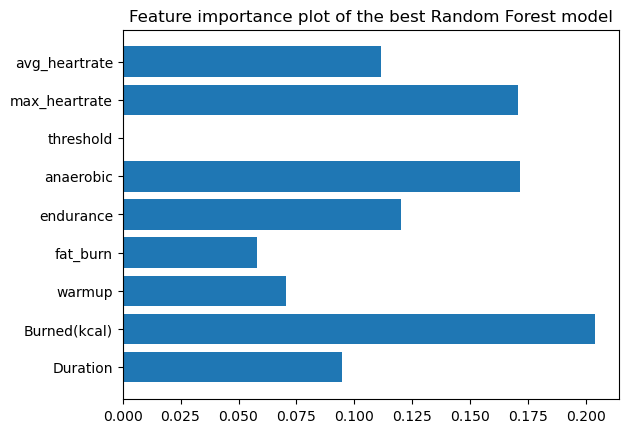

In [12]:
# plot feature importance of the best model
importance = RF_best.feature_importances_
plt.figure()
plt.barh(range(len(importance)), importance)
plt.title('Feature importance plot of the best Random Forest model')
plt.yticks(range(len(importance)), df.drop(['Workout'], axis = 1).columns)
plt.show()


From the plot above, we see that the main features that contribute to the model are the following:
* Burned(kcal)
* Anaerobic (min)
* Max_heartrate (bpm)
* Duration (min)

Looking at the metrics above, the model performs quite well on the test data. However, despite performing well on the metrics above, the dataset that we have is quite small and only 15% is used for testing. Testing the model on a bigger dataset would be more useful and give us more confidence in our predictions. However, based on past research in the field, it has been shown that random forest models perform quite well on classification data and are able to generalize well. This is because random forest models are able to handle a large number of features and are able to handle non-linear relationships between the features and the target variable making them useful in this class of models.  
Also, one concern with the feature importance plot is that duration is a big indicator along with maximum heartrate reached. Both of these features take a long while to measure and would take quite some battery power from any device that it is run on. For example, how does the model know when the duration starts? Moreover, maximum heartrates were achieved quite late on in the workout which also leads to the problem that the model would be unsure as to when the workout started. This is a problem that would need to be addressed in future research.  
To finish the pipeline, I will present a dataframe of what the model predicted for all the values in the test dataset.

In [13]:
# make a dataframe of the test set
df_test = pd.DataFrame(X_test, columns=df.drop(['Workout'], axis = 1).columns)
df_test['Workout'] = y_test
df_test['Predicted'] = y_pred
df_test
reverse_mapper = {0:'Squash', 1:'Basketball', 2:'Volleyball', 3:'Walk', 4:'Gym'}
df_test['Workout'] = df_test['Workout'].map(reverse_mapper)
df_test['Predicted'] = df_test['Predicted'].map(reverse_mapper)
df_test

,Duration,Burned(kcal),warmup,fat_burn,endurance,anaerobic,threshold,max_heartrate,avg_heartrate,Workout,Predicted
0,97,981,14,30,40,12,1,194,156,Squash,Squash
1,23,158,20,3,0,0,0,156,156,Walk,Walk
2,20,149,20,0,0,0,0,143,131,Walk,Walk
3,59,629,5,10,34,11,0,166,142,Squash,Basketball
4,58,277,21,9,28,0,0,154,102,Gym,Walk
5,15,87,15,0,0,0,0,143,134,Walk,Walk
6,87,810,13,25,39,10,0,166,134,Squash,Squash
7,44,502,3,12,26,3,0,166,149,Basketball,Basketball
8,43,305,5,18,14,6,0,154,129,Gym,Gym


# 9. Excecutive summary

Based on the model above, we see that the random forest is trained quite well with it being able to differentiate between the different types of workouts with a high degree of accuracy. This means that the model has a high degree of applicability to real life situations. Moreover, random forest models are not constrained by the number of features and are able to handle non-linear relationships between the features and the target variable. This makes them useful in this class of models since they will be able to handle data from various applications etc.  
Some places where this model could fail is overfitting the training data and not being able to identify which features would not be practical to be used in real life situations e.g. using duration as a big important feature in the model. Moreover, imbalanced data could also potentially cause issues with random forests as they might have high accuracy with the majority class but perform poorly with the minority class.  
The model could be improved by using a bigger dataset and using more features. This would allow the model to be more robust and generalize better.  
In this pipeline, we first exported the data from the health application in a csv format. Then, we processed it so that it could be used in numerical model training, evaluated three commonly used models for classficiation purposes, chose the best model and then tuned the hyperparameters of the model. We then used the model to make predictions on the test data and evaluated the performance of the model. Finally, we visualized the feature importance of the model. This gives us a good example of how Machine Learning can help us find patterns in data and make predictions on unseen data that are actually applicable to real life situations.

# 10. Data ethics

Throughout this pipeline, the data that was used doesn't carry any kind of labels that could connect it to a specific person. Moreover, the purpose of the model was primarily for social good and not targeting any individual or group of people. No malicious practices were followed and all the metrics reported were with honesty making sure that the confidence in model performance was not over-estimated. The data processing and training is explicit, can be repicated on the data and was used in a manner that allowed for easy following along for a reader.

# References

Baheti, P. (2023). Train test validation split: How to &amp; best practices [2023]. V7. Retrieved February 17, 2023, from https://www.v7labs.com/blog/train-validation-test-set#h2

Ronaghan, S. (2019, November 1). The mathematics of decision trees, random forest and feature importance in Scikit-learn and Spark. Medium. Retrieved February 17, 2023, from https://towardsdatascience.com/the-mathematics-of-decision-trees-random-forest-and-feature-importance-in-scikit-learn-and-spark-f2861df67e3 

Link to dataset: https://docs.google.com/spreadsheets/d/15S5Vh6MoREqqiwfwXPP-haM4hHz1sLiUwjsLPMW8Yvo/edit?usp=sharing

Github Link: https://github.com/AbdullahKhurram30/Classification-Pipeline